In [1]:
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt 
import numpy as np  
import lsdb
import pandas as pd
from catalog_filtering import bandFilterLenient, contains_PM

In [2]:
#Bands we care about
bandList = ['G','R','I','Z','Y']

#Keeping only the important columns
crucialCols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)

catalog = lsdb.read_hipscat('hipscat/des_one_deg/', columns=crucialCols)

#Filtering for specific measurement vaTlues
qs = bandFilterLenient(bandList,classStar=0.95,spreadModel=0.05,magError=0.05,flag=True,invalidMags=True)
filtered_catalog = catalog.query(qs)

#Performing crossmatch
xmatch = filtered_catalog.crossmatch(filtered_catalog, n_neighbors=100, radius_arcsec=18, suffixes=['_1', '_2'])

with Client():  
    df = xmatch.compute()

/Users/johnpassos/Documents/LSDB/venv/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [3]:
neighbors = df.groupby('_hipscat_index')['_dist_arcsec'].count()
neighbors -= 1 #Double counting adjustment

In [4]:
df['neighbors'] = neighbors

three_or_more_matches = df.query('neighbors >= 3')
star_groups = three_or_more_matches.groupby('_hipscat_index')

Text(0.5, 1.0, 'Maximum Distance From Line Projection in Each Star Group')

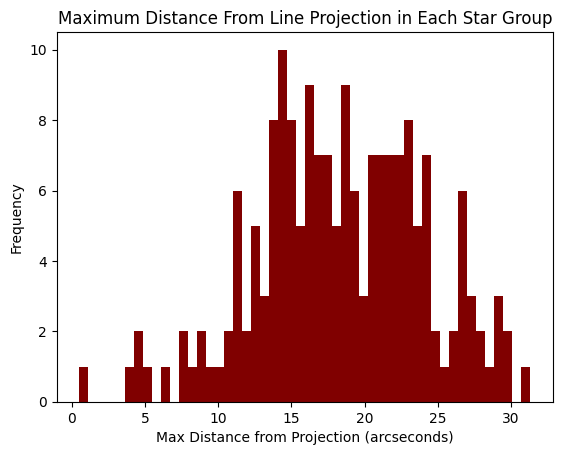

In [81]:
def distance_to_line(PQ, line_vector):
    return np.abs(np.cross(PQ, line_vector)) / np.linalg.norm(line_vector)

def projection_distance(line_vector, x, y):
    PQ = np.array([x, y])
    return distance_to_line(PQ, line_vector)

def id_exists_in_keys(array_1d, array_2d):
    for row in array_2d:
        if np.array_equal(array_1d, row):
            return True
    return False

#Create dictionary to store key value pairs
max_dist_dic = {
    'keys': [],
    'max_distances': []
}

count = 0
for _hipscat_index, group in three_or_more_matches.groupby('_hipscat_index'):
    #array of matched points, make into list of tuples
    ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T
    coords = list(zip(ra2, dec2))

    #collect ids
    id_2 = np.sort(group['COADD_OBJECT_ID_2'].to_numpy().T)

    #check if we've already seen this group
    if (not id_exists_in_keys(id_2, max_dist_dic['keys'])):
        max_dist_dic['keys'].append(id_2)
        max_distance = 0
        for i in range(len(coords)):
            origin_ra, origin_dec = coords[i]
            

            #perform delta RA, DEC calculations, make into list of tuples
            x_vals = (ra2 - origin_ra) * np.cos(np.radians(origin_dec)) * 3600
            y_vals = (dec2 - origin_dec) * 3600
            delta_coords = list(zip(x_vals, y_vals))

            #loop to create line projections
            for j in range(i + 1, len(delta_coords)):
                proj_vector = delta_coords[j]

                #loop to find distances
                for k in range(len(delta_coords)):
                    #only want points not known to be on our projection
                    if (k == j) or (k == i): continue

                    test_x, test_y = delta_coords[k]
                    curr_distance = projection_distance(proj_vector, test_x, test_y)
                    if (curr_distance > max_distance):
                        max_distance = curr_distance
        #at this point, we've found the largest distance in the group
        max_dist_dic['max_distances'].append(max_distance)

distances_df = pd.DataFrame(max_dist_dic)
plt.hist(distances_df['max_distances'], bins = 50, color='maroon')
plt.xlabel('Max Distance from Projection (arcseconds)')
plt.ylabel('Frequency')
plt.title('Maximum Distance From Line Projection in Each Star Group')

#ask dask to run this function for every group (something like .apply() or .map()

In [82]:
distances_df

,keys,max_distances
0,"[1346125718, 1346125733, 1346125861, 1346125972]",14.168895
1,"[1346125718, 1346125733, 1346125861, 134612597...",28.957036
2,"[1346126832, 1346127129, 1346127279, 1346127500]",24.745158
3,"[1346115138, 1346115318, 1346116324, 1346116567]",15.294236
4,"[1345599786, 1345600107, 1345600141, 1345600187]",18.674813
...,...,...
174,"[1342680145, 1342680297, 1342680444, 1342680461]",5.408224
175,"[1342680145, 1342680154, 1342680297, 134268044...",17.204972
176,"[1342680145, 1342680154, 1342680297, 1342680461]",11.151508
177,"[1342664516, 1342664683, 1342664865, 1342664916]",15.681893
